In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#export
from lib.nb_02a import *

`parameter groups`: different groups can have different learning rates/momentum/weight decay... which is what lets us do discriminative learning rates.

### Baseline

In [4]:
x_train, y_train, x_valid, y_valid = get_mnist()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs=64, num_workers=6)
data = Databunch(train_dl, valid_dl, c_in=784, c_out=10)

In [5]:
def get_model(data, lr=0.1):
    model = nn.Sequential(nn.Linear(data.c_in,200), nn.ReLU(), nn.Linear(200, data.c_out))
    return model, optim.SGD

In [6]:
model, opt_func = get_model(data)

cbfs = [partial(AvgStatsCallback,accuracy),ProgressCallback]

learn = Learner(model,data, F.cross_entropy, opt_func, cb_funcs=cbfs)

In [7]:
learn.fit(3)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.369499,0.742220,0.655653,0.856600,00:01
1,0.551683,0.864480,0.424498,0.891300,00:01
2,0.425241,0.886860,0.359487,0.902200,00:01


### Coustome Optimizer

#### Vanilla SGD

In [8]:
class Optimizer():
    
    def __init__(self, params, steppers, **defaults):
        self.param_groups = list(params)
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        
        self.steppers = listify(steppers)
        self.hypers = [{**defaults} for _ in self.param_groups]
        
    def grad_params(self):
        return [(p,hyper) for pg, hyper in zip(self.param_groups,self.hypers) 
                for p in pg if p.grad is not None]
    
    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
            
    def step(self): 
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [9]:
#export
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)
    return p

In [10]:
opt_func = partial(Optimizer, steppers=[sgd_step])

In [11]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

cbfs = [partial(AvgStatsCallback,accuracy),
        Recorder,
        partial(ParamScheduler, 'lr', sched), ProgressCallback]

model, _ = get_model(data)
learn = Learner(model,data, F.cross_entropy, opt_func=opt_func, cb_funcs=cbfs)

In [12]:
learn.fit(3)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.327144,0.903140,0.153593,0.955700,00:02
1,0.117681,0.964300,0.112822,0.966200,00:02
2,0.065659,0.980820,0.079242,0.977100,00:02


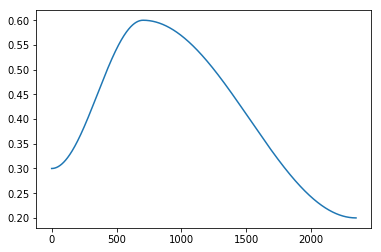

In [13]:
learn.recorder.plot_lr()

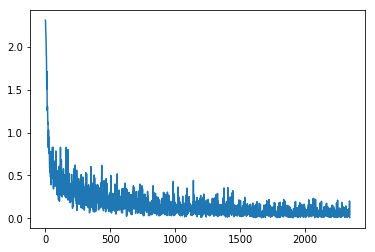

In [14]:
learn.recorder.plot_loss()

#### Weight Decay

In [15]:
#export
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1-lr*wd)
    return p
weight_decay._defaults = dict(wd=0.)

In [16]:
#export
def maybe_update(os, dest, f):
    for o in os:
        for k, v in f(o).items():
            if k not in dest: dest[k]=v
                
def get_defaults(s): return getattr(s, "_defaults", {})

In [17]:
#export
class Optimizer():
    
    def __init__(self, params, steppers, **defaults):
        
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        
        self.param_groups = list(params)
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for _ in self.param_groups]
        
    def grad_params(self):
        return [(p,hyper) for pg, hyper in zip(self.param_groups,self.hypers) 
                for p in pg if p.grad is not None]
    
    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
            
    def step(self): 
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [18]:
#export
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

In [19]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

cbfs = [partial(AvgStatsCallback,accuracy),
        Recorder,
        partial(ParamScheduler, 'lr', sched), ProgressCallback]

model, _ = get_model(data)
learn = Learner(model,data, F.cross_entropy, opt_func=sgd_opt, cb_funcs=cbfs)

In [20]:
model = learn.model 

In [21]:
opt_func = sgd_opt(model.parameters(), lr=0.1,wd=0.8)
test_eq(opt_func.hypers[0]["wd"],0.8)

In [22]:
opt_func = sgd_opt(model.parameters(), lr=0.1)
test_eq(opt_func.hypers[0]['wd'], 0.)

In [23]:
learn.fit(3)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.326408,0.903740,0.157026,0.955200,00:02
1,0.117666,0.964240,0.098201,0.970200,00:02
2,0.065946,0.980780,0.079381,0.976600,00:03


#### Momentum

In [24]:
#export
class StatefulOptimizer(Optimizer):
    
    def __init__(self, params, steppers, stats=None, **defaults):
        self.stats = listify(stats)
        maybe_update(self.stats, defaults, get_defaults)
        
        super().__init__(params, steppers, **defaults)
        self.state = {}
        
    def step(self):
        for p,hyper in self.grad_params():
            if p not in self.state:
                self.state[p] = {}
                maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
            state = self.state[p]
            for stat in self.stats: state = stat.update(p, state, **hyper)
            compose(p, self.steppers, **state, **hyper)
            self.state[p] = state

In [25]:
#export
class Stat():
    _defaults = {}
    def init_state(self, p): raise NotImplementedError
    def update(self, p, state, **kwargs): raise NotImplementedError    

In [26]:
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)

    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(p.grad.data)
        return state

In [27]:
#export
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg)
    return p

In [28]:
sgd_mom_opt = partial(StatefulOptimizer, steppers=[momentum_step,weight_decay],
                  stats=AverageGrad(), wd=0.01, mom=0.2)

In [29]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

cbfs = [partial(AvgStatsCallback,accuracy),
        Recorder,
        partial(ParamScheduler, 'lr', sched), ProgressCallback]

model, _ = get_model(data)
learn = Learner(model,data, F.cross_entropy, opt_func=sgd_mom_opt, cb_funcs=cbfs)

In [30]:
learn.fit(3)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.417625,0.877760,0.430666,0.870500,00:02
1,0.306549,0.912520,0.288058,0.916900,00:02
2,0.255745,0.934720,0.294040,0.913600,00:02


In [31]:
learn.opt.hypers

[{'wd': 0.01, 'mom': 0.2, 'lr': 0.20000036594989024}]

In [32]:
learn.opt.state

{Parameter containing:
 tensor([[-3.3150e-07,  4.0630e-07,  7.2425e-07,  ...,  1.7140e-06,
           1.7862e-06,  3.4208e-07],
         [ 1.6926e-06,  9.6197e-07,  3.3203e-07,  ...,  5.2589e-07,
           1.1118e-06, -1.5117e-06],
         [ 1.8180e-06, -1.7324e-06, -7.8283e-08,  ..., -1.8217e-06,
           4.6843e-07,  9.1865e-07],
         ...,
         [-1.9360e-06, -8.5823e-07, -8.4973e-07,  ..., -2.6484e-07,
          -2.7098e-07, -6.3498e-07],
         [ 3.9819e-07,  9.5702e-07, -3.3979e-07,  ..., -1.6343e-06,
           1.8681e-06, -3.8789e-09],
         [ 6.0427e-07,  9.4975e-07, -4.7002e-07,  ..., -3.1933e-07,
          -7.5432e-07,  3.2746e-07]], requires_grad=True): {'grad_avg': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]])}, Parameter containing:
 tensor(

#### Momentum Experiments

In [33]:
x = torch.linspace(-4,4,200)
y = torch.randn(200)+0.3
betas = [0.5, 0.7, 0.9, 0.99]

In [34]:
def plot_mom(f):
    _, ax = plt.subplots(2,2, figsize=(12,8))
    for beta, ax in zip(betas, ax.flatten()):
        ax.plot(y, linestyle="None", marker=".")
        avg,res = None,[]
        for i, yi in enumerate(y):
            avg,p = f(avg, beta, yi, i)
            res.append(p)
        ax.plot(res, color="red")
        ax.set_title(f"beta={beta}")

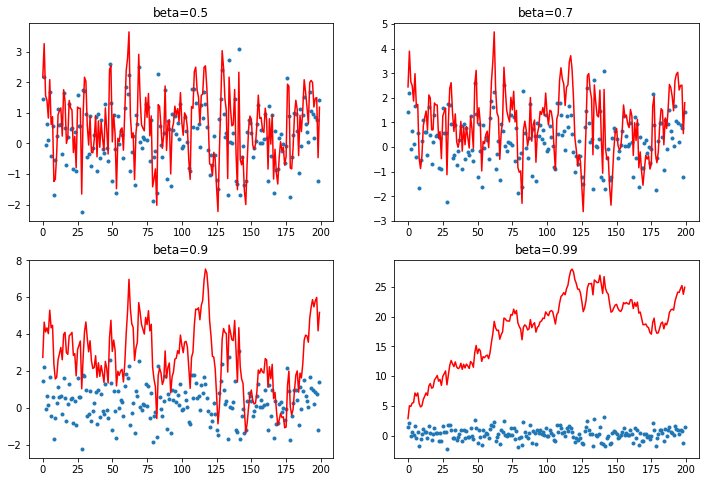

In [35]:
def mom1(avg, beta, yi, i): 
    if avg is None: avg=yi
    res = beta*avg + yi
    return res,res
plot_mom(mom1)

In [36]:
def lin_comb(v1, v2, beta): return beta*v1 + (1-beta)*v2

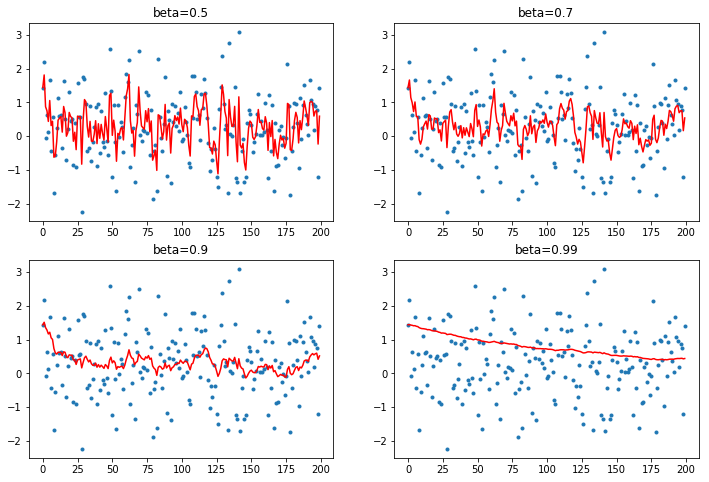

In [37]:
def mom2(avg, beta, yi, i):
    if avg is None: avg=yi
    avg = lin_comb(avg, yi, beta)
    return avg, avg
plot_mom(mom2)

In [38]:
y = 1 - (x/3) ** 2 + torch.randn(200) * 0.1
y[0]=0.5

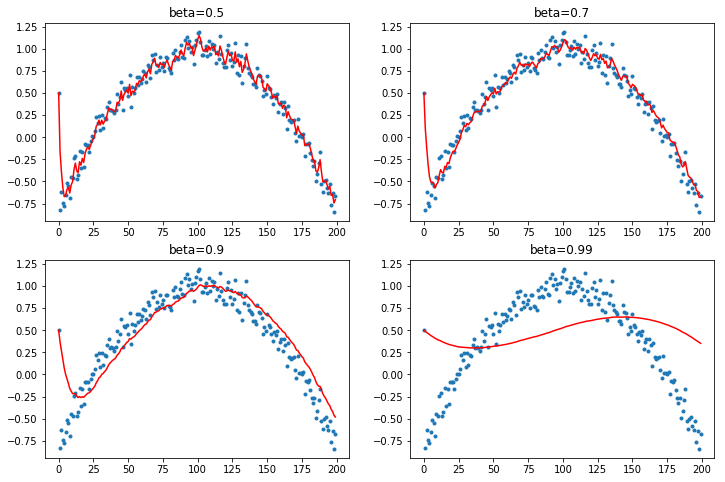

In [39]:
plot_mom(mom2)

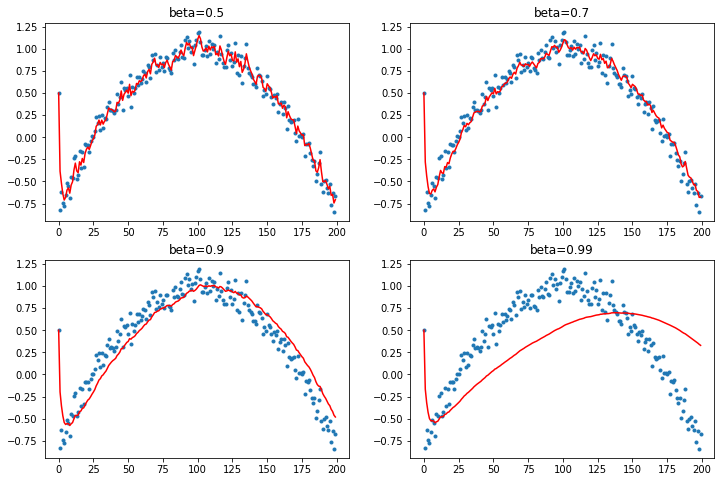

In [40]:
def mom3(avg, beta, yi, i):
    if avg is None: avg=0
    avg = lin_comb(avg, yi, beta)
    return avg, avg/(1-beta**(i+1))
plot_mom(mom3)

In [41]:
#export
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def __init__(self, dampening:bool=False): self.dampening=dampening
    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['mom_damp'] = 1-mom if self.dampening else 1.
        state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)
        return state

In [42]:
#export
sgd_mom_opt = partial(StatefulOptimizer, steppers=[momentum_step,weight_decay],
                  stats=AverageGrad(), wd=0.01, mom=0.2)

In [43]:
#export
class AverageSqrGrad(Stat):
    _defaults = dict(sqr_mom=0.99)
    
    def __init__(self, dampening:bool=True): self.dampening=dampening
    def init_state(self, p): return {'sqr_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1-sqr_mom if self.dampening else 1.
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data, p.grad.data)
        return state

In [44]:
#export
class StepCount(Stat):
    def init_state(self, p): return {'step': 0}
    def update(self, p, state, **kwargs):
        state['step'] += 1
        return state

In [45]:
#export
def debias(mom, damp, step): return damp * (1 - mom**step) / (1-mom)

In [46]:
#export
def adam_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    p.data.addcdiv_(-lr / debias1, grad_avg, (sqr_avg/debias2).sqrt() + eps)
    return p
adam_step._defaults = dict(eps=1e-5)

In [47]:
#export
def adam_opt(xtra_step=None, **kwargs):
    return partial(StatefulOptimizer, steppers=[adam_step,weight_decay]+listify(xtra_step),
                   stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()], **kwargs)

In [48]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

cbfs = [partial(AvgStatsCallback,accuracy),
        Recorder, ProgressCallback]

model, _ = get_model(data)
learn = Learner(model,data, F.cross_entropy, opt_func=adam_opt(), cb_funcs=cbfs)

In [49]:
learn.fit(3)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.233866,0.928880,0.130057,0.961200,00:02
1,0.137942,0.961580,0.142019,0.959500,00:03
2,0.108023,0.969660,0.151420,0.965000,00:03


In [50]:
#export
def lamb_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, wd, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    r1 = p.data.pow(2).mean().sqrt()
    step = (grad_avg/debias1) / ((sqr_avg/debias2).sqrt()+eps) + wd*p.data
    r2 = step.pow(2).mean().sqrt()
    p.data.add_(-lr * min(r1/r2,10), step)
    return p
lamb_step._defaults = dict(eps=1e-6, wd=0.)

In [51]:
#export
lamb = partial(StatefulOptimizer, 
               steppers=lamb_step, stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()])

In [52]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

cbfs = [partial(AvgStatsCallback,accuracy),
        Recorder, ProgressCallback]

model, _ = get_model(data)
learn = Learner(model,data, F.cross_entropy, opt_func=lamb, cb_funcs=cbfs)

In [53]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.347168,0.905700,0.150383,0.956000,00:03


In [54]:
!python3 notebook2script.py 03_optimizers.ipynb

Converted 03_optimizers.ipynb to lib/nb_03.py
